In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
#from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Adjusting tau and std to create the tuning curve shape

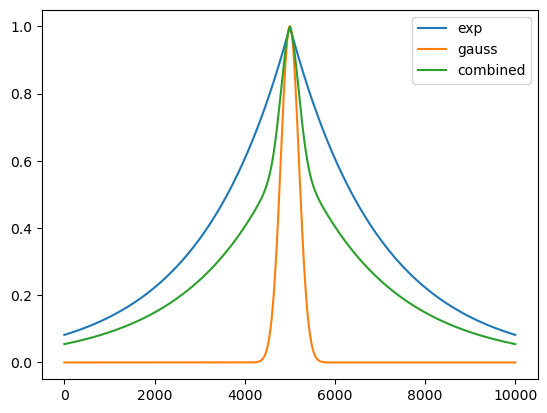

In [7]:
kerel_size = 10000
tau = 2000
g_std = 200
k_gauss = gaussian(kerel_size, std=g_std, sym=True)
k_exp = exponential(kerel_size, tau=tau, sym=True)
plt.plot(k_exp, label='exp')
plt.plot(k_gauss, label='gauss')
plt.plot((k_exp+k_gauss/2)/1.5, label='combined')
plt.legend()

# Plotting different Filters, with increasing variance and kernel size

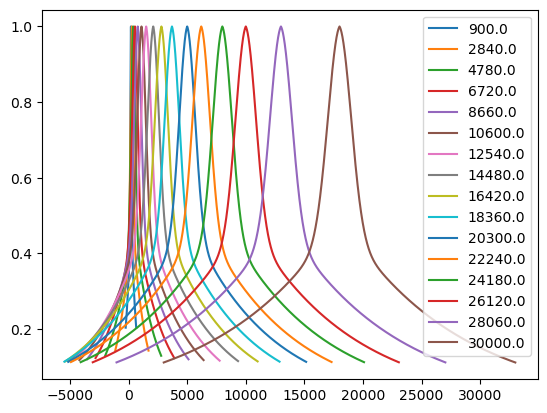

: 

In [8]:
kernels = []
freq_centers = [200,280,390,540,780,1100,1500,2100,2800,3700,5000,6200,8000,10000,13000,18000]
kernel_sizes = np.linspace(900,30000,16)
kernels_xs = []
taus = np.linspace(500,10000,16)
stds = np.linspace(50,1000,16)



for k, center,tau,g_std in zip(kernel_sizes,freq_centers,taus,stds):
    k_gauss = gaussian(k, std=g_std, sym=True)
    k_exp = exponential(k, tau=tau, sym=True)
    kernel = k_gauss + k_exp
    kernel /= np.max(kernel)
    kernels.append(kernel)
    x_coords = np.arange(k)
    k_x = x_coords - (k/2) + center
    kernels_xs.append(k_x)

    plt.plot(k_x,kernel, label=str(k))

plt.legend()

# Human like tuning curves

curve 1: mid = 200 Hz, low = 15%
curve 2: mid = 280 Hz, low = 12.5%
curve 3: mid = 390 Hz, low = 12%
curve 4: mid = 540 Hz, low = 12.5%
curve 5: mid = 780 Hz, low = 12.5%
curve 6: mid = 1100 Hz, low = 11%
curve 7: mid = 1500 Hz, low = 10%
curve 8: mid = 2100 Hz, low = 6%
curve 9: mid = 2800 Hz, low = 7.5%
curve 10: mid = 3700 Hz, low = 6%
curve 11: mid = 5000 Hz, low = 8%
curve 12: mid = 6200 Hz, low = 9%
curve 13: mid = 8000 Hz, low = 10%
curve 14: mid = 10000 Hz, low = 12%
curve 15: mid = 13000 Hz, low = 16%
curve 16: mid = 18000 Hz, low = 20%

In [9]:
from datasets import load_dataset
data = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
samp = data['audio'][0].values()
samp.shape

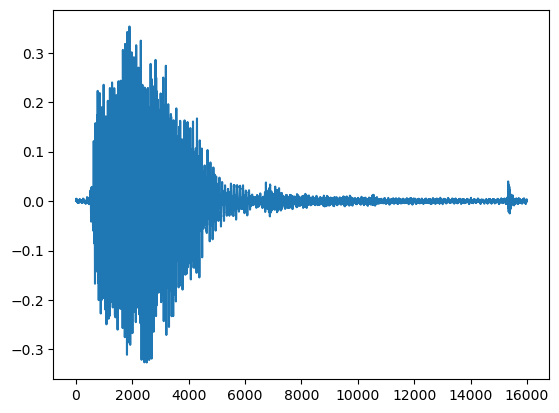

In [ ]:
plt.plot(samp)

# Applying all 16 Filters to sample audio seperately

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import exponential, gaussian

# Generate a sample signal with noise
fs = 16000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time array
#signal = np.sin(2 * np.pi * 7 * t) + 0.5 * np.sin(2 * np.pi * 15 * t)
signal = samp
noise = np.random.normal(0, 0.3, t.shape)  # White Gaussian noise
noisy_signal = signal + noise

# Define a function to create an individual kernel
def create_individual_kernel(kernel_size, tau, g_std, middle):
    k_gauss = gaussian(kernel_size, std=g_std, sym=True)
    k_exp = exponential(kernel_size, tau=tau, sym=True)
    combined = k_gauss + k_exp
    # Shift the middle point
    shift = middle - kernel_size // 2
    combined = np.roll(combined, shift)
    combined /= np.max(combined)  # Normalize the kernel
    return combined

def create_individual_kernel_0(kernel_size, tau, g_std, middle, assume_circular=False):
    # match the kernel size such that middle is in the middle of the kernel
    original_kernel_size = kernel_size
    shift = middle - kernel_size // 2
    if not assume_circular:
        # extend the kernel size to accommodate the shift
        kernel_size = kernel_size + 2*np.abs(shift)

    k_gauss = gaussian(kernel_size, std=g_std, sym=True)
    k_exp = exponential(kernel_size, tau=tau, sym=True)
    combined = k_gauss + k_exp

    if assume_circular:
        combined = np.roll(combined, shift)
    else:
        # crop the kernel to the original size
        if shift < 0: # if negative shift, take the end of the wrapper kernel
            combined = combined[-original_kernel_size:]
        else: # if positive shift, take the beginning of the wrapper kernel
            combined = combined[:original_kernel_size]

    combined /= np.max(combined)  # Normalize the kernel
    return combined

# Define kernel parameters (tau, g_std, middle)
params = [
    (400, 40, 200),
    (1040, 104, 280),
    (1680, 168, 390),
    (2320, 232, 540),
    (2960, 296, 780),
    (3600, 360, 1100),
    (4240, 424, 1500),
    (4880, 488, 2100),
    (5520, 552, 2800),
    (6160, 616, 3700),
    (6800, 680, 5000),
    (7440, 744, 6200),
    (8080, 808, 8000),
    (8720, 872, 10000),
    (9360, 936, 13000),
    (10000, 1000, 18000)
]

# Perform FFT to get the frequency domain representation
frequencies = np.fft.fftfreq(len(noisy_signal), d=1/fs)
fft_signal = np.fft.fft(noisy_signal)
plt.plot(frequencies, fft_signal)

TypeError: unsupported operand type(s) for +: 'dict_values' and 'float'

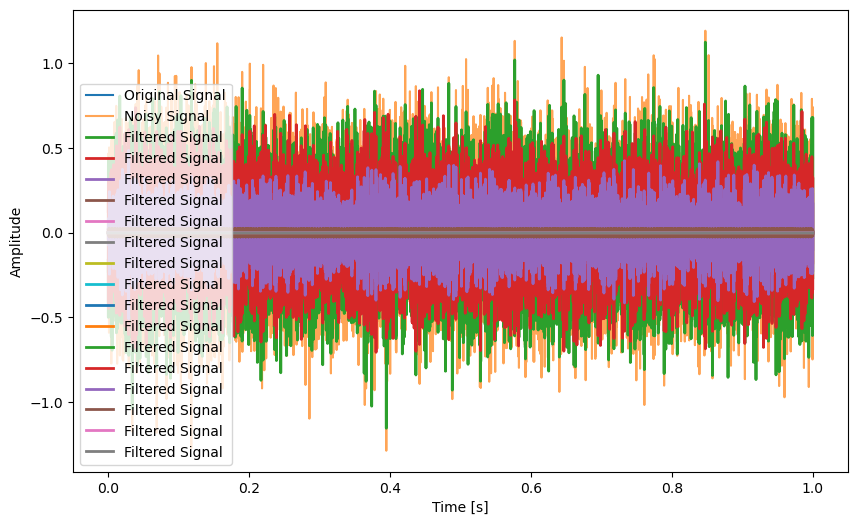

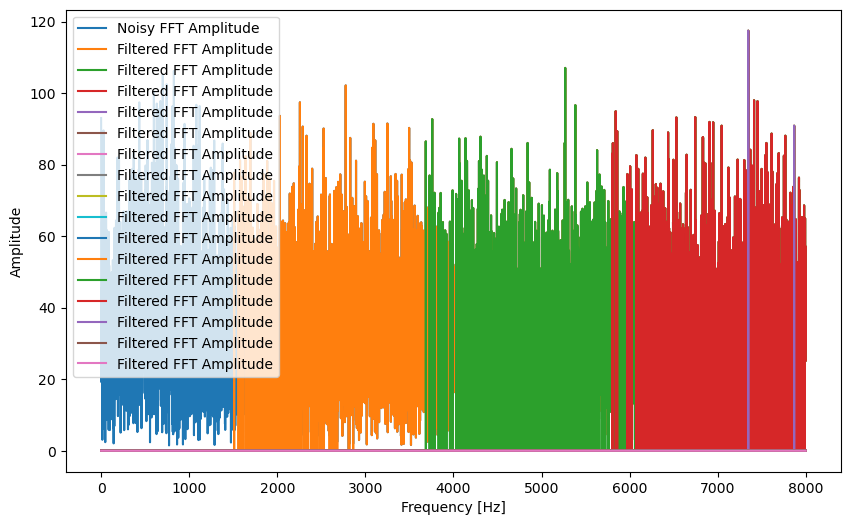

"\n# Plot the individual kernels for reference\nplt.figure(figsize=(10, 6))\nfor tau, g_std, middle in params:\n    kernel = create_individual_kernel(len(noisy_signal), tau, g_std, middle)\n    plt.plot(np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2], label=f'Kernel tau={tau}, g_std={g_std}, middle={middle}')\nplt.xlabel('Frequency [Hz]')\nplt.ylabel('Threshold Amplitude')\nplt.legend()\nplt.show()\n"

In [ ]:
attenuation_factors = np.ones_like(fft_signal)
factors = []
# Apply each kernel independently
for tau, g_std, middle in params:
    kernel = create_individual_kernel(len(noisy_signal), tau, g_std, middle)
    thresholds = np.interp(np.abs(frequencies), np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2])*np.mean(np.abs(frequencies))

    current_factors = np.where(np.abs(fft_signal) < thresholds, 0, 1)
    factors.append(current_factors)
    #attenuation_factors = np.minimum(attenuation_factors, current_factors)

plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
# Apply the combined attenuation factors
for f in factors:
    filtered_fft_signal = fft_signal * f

# Perform inverse FFT to get back the time domain signal
    filtered_signal = np.fft.ifft(filtered_fft_signal)

# Plot the original, noisy, and filtered signals
    plt.plot(t, filtered_signal.real, label='Filtered Signal', linewidth=2)  # Use .real to avoid plotting imaginary part
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the frequency domain representation for verification
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2], label='Noisy FFT Amplitude')
for f in factors:
    filtered_fft_signal = fft_signal * f

# Perform inverse FFT to get back the time domain signal
    filtered_signal = np.fft.ifft(filtered_fft_signal)

    plt.plot(frequencies[:len(frequencies)//2], np.abs(filtered_fft_signal)[:len(frequencies)//2], label='Filtered FFT Amplitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
"""
# Plot the individual kernels for reference
plt.figure(figsize=(10, 6))
for tau, g_std, middle in params:
    kernel = create_individual_kernel(len(noisy_signal), tau, g_std, middle)
    plt.plot(np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2], label=f'Kernel tau={tau}, g_std={g_std}, middle={middle}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Threshold Amplitude')
plt.legend()
plt.show()
"""

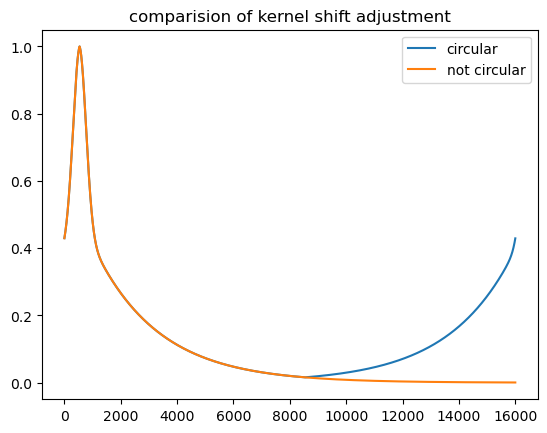

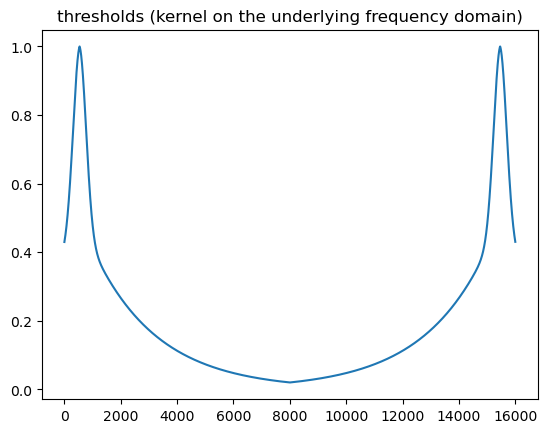

In [99]:
# comparision of circular and non-circular kernel shift adjustment
kernel = create_individual_kernel(len(noisy_signal), *params[3])
kernel_0 = create_individual_kernel_0(len(noisy_signal), *params[3], assume_circular=False)

plt.plot(kernel, label="circular")
plt.plot(kernel_0, label="not circular")
plt.title("comparision of kernel shift adjustment")
plt.legend()
plt.show()

kernel = kernel_0
thresholds = np.interp(np.abs(frequencies), np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2])
    
# print("min max thresholds: ", np.min(thresholds), np.max(thresholds))
# print("min max amplitudes: ", np.min(np.abs(fft_signal)), np.max(np.abs(fft_signal)))
plt.plot(thresholds)
plt.title("thresholds (kernel on the underlying frequency domain)")
plt.show()

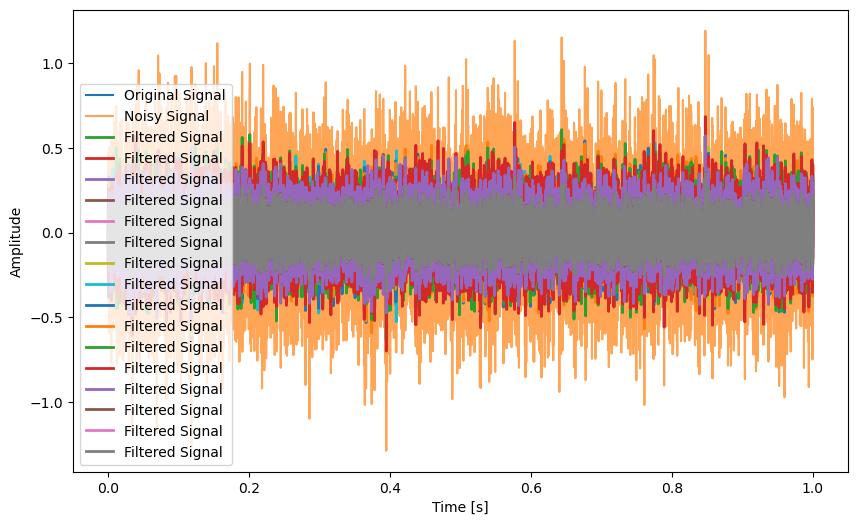

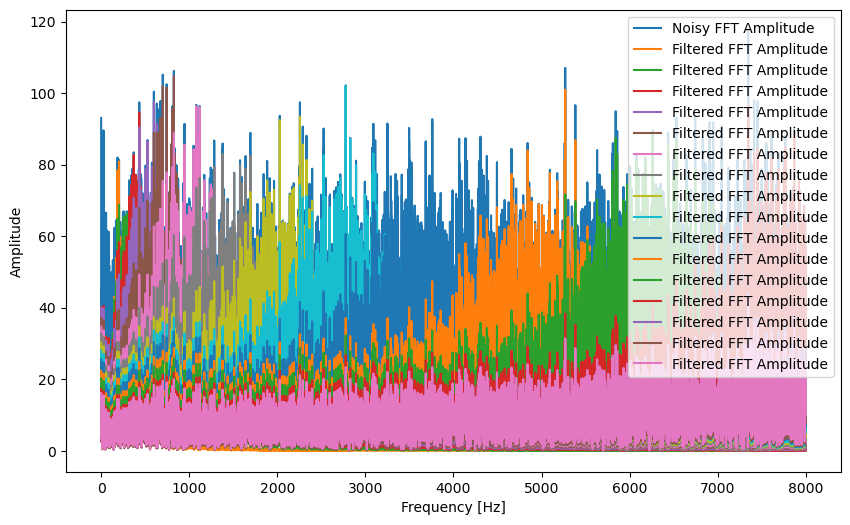

"\n# Plot the individual kernels for reference\nplt.figure(figsize=(10, 6))\nfor tau, g_std, middle in params:\n    kernel = create_individual_kernel(len(noisy_signal), tau, g_std, middle)\n    plt.plot(np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2], label=f'Kernel tau={tau}, g_std={g_std}, middle={middle}')\nplt.xlabel('Frequency [Hz]')\nplt.ylabel('Threshold Amplitude')\nplt.legend()\nplt.show()\n"

In [97]:
# Initialize an array to store the minimum attenuation factors
attenuation_factors = np.ones_like(fft_signal)
factors = []
# match the filters to the given frequencies ( the step with np.interp)
for tau, g_std, middle in params:
    kernel = create_individual_kernel_0(len(noisy_signal), tau, g_std, middle, assume_circular=False)
    thresholds = np.interp(np.abs(frequencies), np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2])
    factors.append(thresholds)

plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
# Apply the combined attenuation factors
for f in factors:
    filtered_fft_signal = fft_signal * f

# Perform inverse FFT to get back the time domain signal
    filtered_signal = np.fft.ifft(filtered_fft_signal)

# Plot the original, noisy, and filtered signals
    plt.plot(t, filtered_signal.real, label='Filtered Signal', linewidth=2)  # Use .real to avoid plotting imaginary part
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the frequency domain representation for verification
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2], label='Noisy FFT Amplitude')
for f in factors:
    filtered_fft_signal = fft_signal * f

# Perform inverse FFT to get back the time domain signal
    filtered_signal = np.fft.ifft(filtered_fft_signal)

    plt.plot(frequencies[:len(frequencies)//2], np.abs(filtered_fft_signal)[:len(frequencies)//2], label='Filtered FFT Amplitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
"""
# Plot the individual kernels for reference
plt.figure(figsize=(10, 6))
for tau, g_std, middle in params:
    kernel = create_individual_kernel(len(noisy_signal), tau, g_std, middle)
    plt.plot(np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2], label=f'Kernel tau={tau}, g_std={g_std}, middle={middle}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Threshold Amplitude')
plt.legend()
plt.show()
"""

In [8]:
from datasets import load_dataset
from speech2spikes import S2S
import torchaudio
#data = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
s2s = S2S()

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [ ]:
batch = []
for i in range(124):
    batch.append(train_set[i][0])
labels = [torch.Tensor(0)] * 124

s2s = S2S()
tensors, targets = s2s(list(zip(batch, labels)))

In [40]:
# ran into some issues, because it seems like not all samples have the same length, will fix soon
filtered_signal_batches = np.zeros((16,124,1,16000))
for i,b in enumerate(batch):
    frequencies = np.fft.fftfreq(len(b[0]), d=1/fs)
    fft_signal = np.fft.fft(b[0])
    factors = []
    # Initialize an array to store the minimum attenuation factors
    attenuation_factors = np.ones_like(b[0])
    for j, (tau, g_std, middle) in enumerate(params):
        kernel = create_individual_kernel(len(b[0]), tau, g_std, middle)
        thresholds = np.interp(np.abs(frequencies), np.linspace(0, fs/2, len(kernel)//2), kernel[:len(kernel)//2])*np.mean(np.abs(frequencies))
        current_factors = np.where(np.abs(fft_signal) < thresholds, 0, 1)
        #factors.append(current_factors)
        filtered_fft_signal = fft_signal * current_factors
        filtered_signal = np.fft.ifft(filtered_fft_signal)
        filtered_signal_batches[j,i,0] = filtered_signal

C:\Users\wasse\AppData\Local\Temp\ipykernel_4200\1823276149.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  filtered_signal_batches[j,i,0] = filtered_signal


ValueError: could not broadcast input array from shape (10922,) into shape (16000,)

In [5]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)